In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [185]:
iris=datasets.load_iris()

In [186]:
X_train=iris.data[:, 2:4]
X_train[:20]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3]])

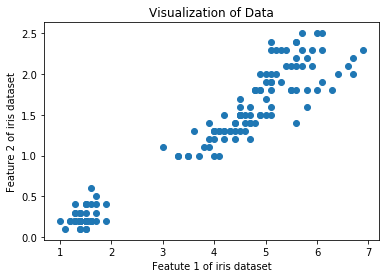

In [187]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.xlabel('Featute 1 of iris dataset')
plt.ylabel('Feature 2 of iris dataset')
plt.title('Visualization of Data')
plt.show()

In [188]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)

In [189]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1,1)

In [190]:
from sklearn.cluster import KMeans
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [191]:
from scipy.stats import multivariate_normal
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

In [192]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k 
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k 
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [193]:
def get_loglikelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [194]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_loglikelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

In [195]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X_train, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -1208.1955112745395
Epoch:  2 Likelihood:  -497.27550009883583
Epoch:  3 Likelihood:  -402.9125982786153
Epoch:  4 Likelihood:  -314.17502789943165
Epoch:  5 Likelihood:  -305.78033581792357
Epoch:  6 Likelihood:  -295.7080751431756
Epoch:  7 Likelihood:  -285.182901883239
Epoch:  8 Likelihood:  -278.5440254891216
Epoch:  9 Likelihood:  -276.35676262297363
Epoch:  10 Likelihood:  -275.9001433683995
Epoch:  11 Likelihood:  -275.80351836662976
Epoch:  12 Likelihood:  -275.7626166821503
Epoch:  13 Likelihood:  -275.73085359837876
Epoch:  14 Likelihood:  -275.70184229043366
Epoch:  15 Likelihood:  -275.67462703084857
Epoch:  16 Likelihood:  -275.6489976065318
Epoch:  17 Likelihood:  -275.624864501886
Epoch:  18 Likelihood:  -275.60216819562925
Epoch:  19 Likelihood:  -275.58086251976647
Epoch:  20 Likelihood:  -275.56090940747646
Epoch:  21 Likelihood:  -275.54227577536005
Epoch:  22 Likelihood:  -275.52493104030594
Epoch:  23 Likelihood:  -275.5088450150527
Epoch:  

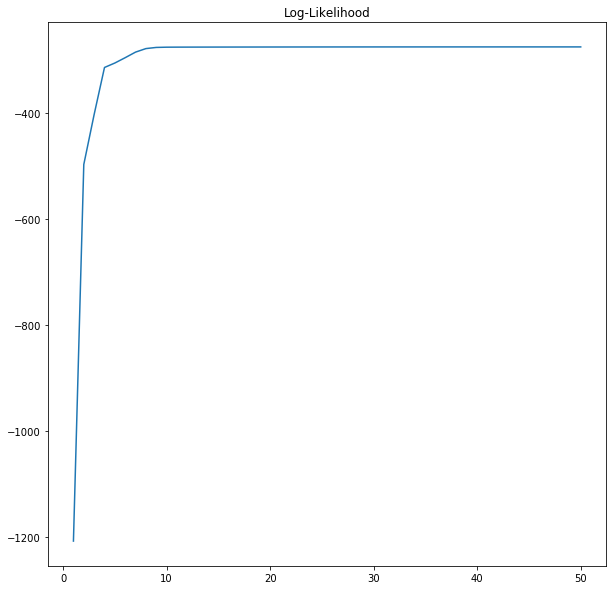

In [196]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()